In [2]:
import seaborn as sns
from adaptive.compute import collect
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from time import time
from glob import glob
import scipy.stats as stats
from IPython.display import display, HTML
from adaptive.saving import *
import dill as pickle
from pickle import UnpicklingError
import copy
from itertools import compress
import scipy.stats as stats
from plot_utils import *
import os
sns.set_context("notebook", font_scale=1.3)
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Synthetic example
### Data generating process
Use the _tree_ data-generating process. 

Denote the signal_strength as $\alpha$.

- Consider $K=4$ arms: $\{w_0, w_1, w_2, w_3\}$. 
- Context space: $\mathbb{R}^3$, and each $(x_0, x_1, x_2)$ is sampled from $\mathcal{N}(0,I_3)$. $x_2$ is noise.
- Split the covariate X-space $(x_0, x_1)$ into four regions, split=$0.5$.
- In region $i$, arm $j$ has expected reward $\gamma1_{[i=j]}+\mathcal{N}(0,1)$.


             ^ x1
             |
         Arm 1 best  |    Arm 3 best
             |       |
     ~~~~~~~~|~(split,split)~~~~~~
             |       |
         Arm 0 best  |    Arm 2 best
     ------(0,0)------------------>x0
             |       |
             |       |
             |       |
             |       |

####  Different scenarios
+ $\gamma=0.5$: signal
+ $\gamma=0$: no-signal

### Policies:
1. __optimal contextual policy__ that assigns each context to the optimal arm
2. __best fixed_arm policy__ that always assigns each context to arm $w_0$;
3. __contrast__ between the above policies.
We demonstrate the contrast estimation here.

### Compared estimation methods:
- DM: direct method;
- DR: doubly-robust method with weight $h_t=1$;
- non-contextual `MinVar` $h_t = 1/E[\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}]$
- non-contextual `StableVar` $h_t = 1/\sqrt{E[\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}]}$
- contextual `MinVar` $h_t(x) = 1/\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}$
- contextual `StableVar` $h_t(x) = 1/\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}$

In [3]:
def read_data(name):
    results = read_files(f'{name}*')
    print(len(results))
    if os.path.exists(f"{name}_stats.csv"):
        df_stats = pd.read_csv(f"{name}_stats.csv")
    else:
        df_stats, CONFIG_COLS, confidence_level = generate_data_frames(results)
        df_stats.to_csv(f"{name}_stats.csv")
    return df_stats

In [4]:
df_stats_signal = read_data('results/synthetic_signal')
df_stats_signal['sig'] = 'Signal'
df_stats_nosignal = read_data('results/synthetic_nosignal')
df_stats_nosignal['sig'] = 'No Signal'
df_stats = pd.concat([df_stats_signal, df_stats_nosignal])

Found 1 files.
Skipping corrupted file: results/synthetic_signal_stats.csv
0
Found 1 files.
Skipping corrupted file: results/synthetic_nosignal_stats.csv
0


## Evolution of estimates of the contrast.
X-axis is the sample size. Error bars are $95\%$ confidence intervals averages across $1000$ replications.

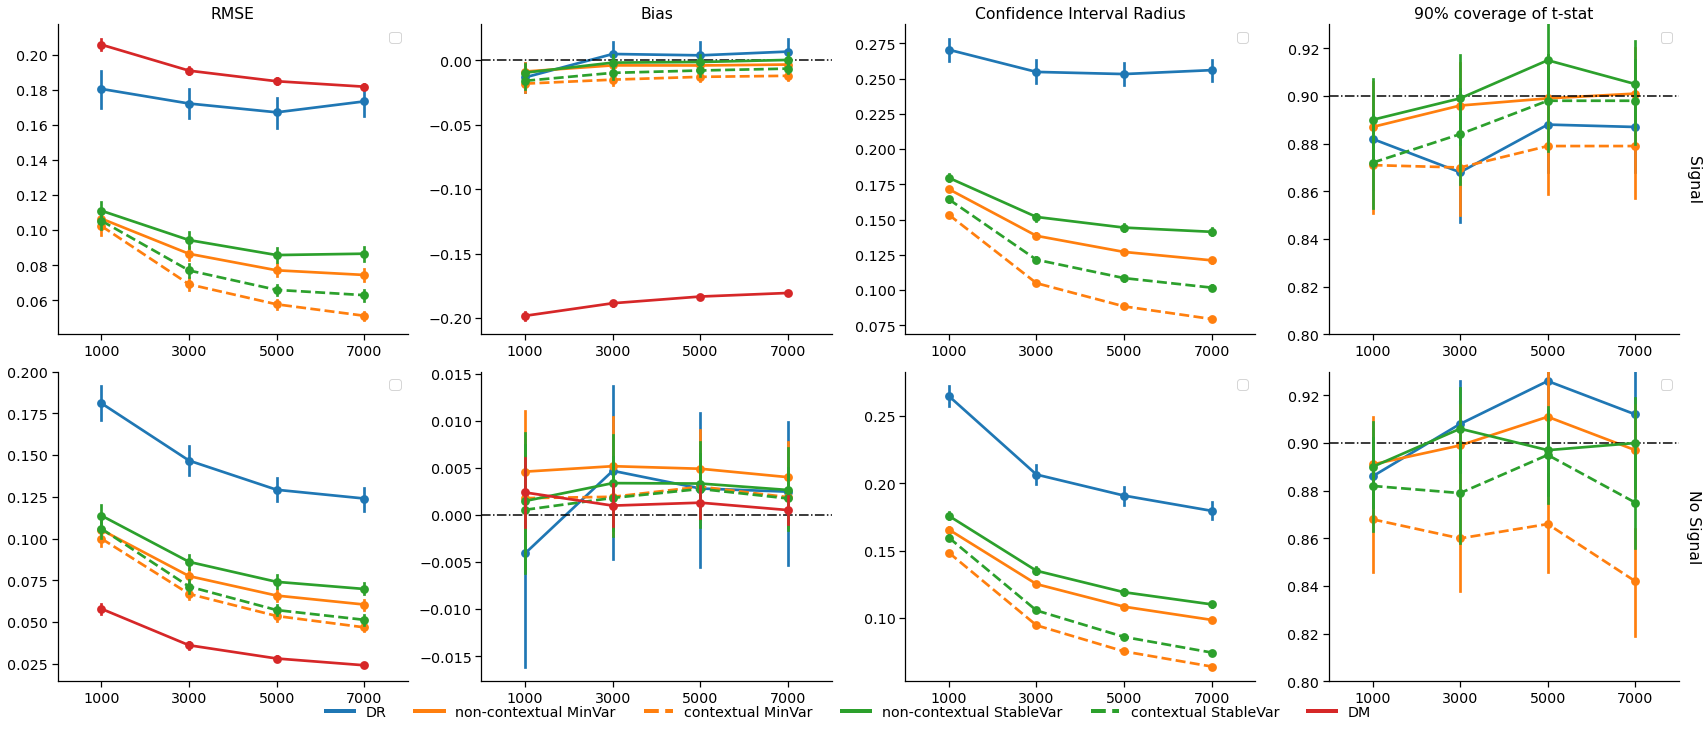

In [5]:
sns.set_context( font_scale=1.5)
plot_statistics(df_stats.query("policy=='optimal-best_arm'"), row='sig')